In [1]:
##import the required libraries and APIs
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense



import matplotlib.pyplot as plt


import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

print(tf.__version__)

2.15.0


In [2]:
#importing the preprocessed data 
df= pd.read_csv('../data/processed/preprocessed_dataset.csv')

In [3]:
df.head()
df.columns

Index(['Unnamed: 0.1', 'Movie Title', 'Plot Summary', 'Cover Image', 'Year',
       'Source', 'Rated', 'omdb Year', 'omdb Title', 'Released', 'Runtime',
       'Genre', 'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country',
       'Awards', 'Poster', 'Ratings', 'imdbRating', 'BoxOffice', 'imdbID',
       'ProcessedPlot'],
      dtype='object')

In [4]:
#create corpus from preprocessed plot
corpus=df['ProcessedPlot']
print(corpus[5])

attending college new york city sophomore al freshman imogen begin dating three month fallen love imogen aspiring artist arranges private showing art gallery al birthday two sex first time al roommate monk become pornographic film actor director tell love illusory fleeting monk costar cyrus flirt al al loses bet must perform extra one monk film cause argument imogen want spend time go france summer abandon film favor spending night france imogen asked cousin al marry unnerves nineteen act differently toward al return father host cooking show want fatherandson show al graduate al would rather pursue dream becoming chef french cuisine concerned imogen drifting apart al arranges picnic countryside way back drive drunk crash tree seeing accident sign try improve relationship though seem happy monk predicts precursor breakup imogen decline sex one night al feel emasculated sexual fantasy cyrus imogen fear may pregnant though turn strain relationship one monk party cyrus try seduce al declin

# Set up tokenizer 

In [6]:
tokenizer.fit_on_texts(corpus)

##calculate vocabulary size 
vocab_size = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(vocab_size)

{'find': 1, 'tell': 2, 'one': 3, 'take': 4, 'go': 5, 'back': 6, 'get': 7, 'father': 8, 'friend': 9, 'home': 10, 'later': 11, 'family': 12, 'kill': 13, 'new': 14, 'return': 15, 'house': 16, 'two': 17, 'life': 18, 'mother': 19, 'day': 20, 'help': 21, 'time': 22, 'meet': 23, 'make': 24, 'escape': 25, 'year': 26, 'see': 27, 'try': 28, 'begin': 29, 'also': 30, 'night': 31, 'give': 32, 'attempt': 33, 'reveals': 34, 'car': 35, 'police': 36, 'death': 37, 'man': 38, 'child': 39, 'next': 40, 'call': 41, 'away': 42, 'school': 43, 'son': 44, 'leaf': 45, 'however': 46, 'work': 47, 'killed': 48, 'first': 49, 'woman': 50, 'group': 51, 'love': 52, 'show': 53, 'end': 54, 'come': 55, 'leave': 56, 'wife': 57, 'daughter': 58, 'team': 59, 'asks': 60, 'arrives': 61, 'another': 62, 'attack': 63, 'fight': 64, 'run': 65, 'film': 66, 'plan': 67, 'money': 68, 'becomes': 69, 'discovers': 70, 'way': 71, 'brother': 72, 'party': 73, 'together': 74, 'named': 75, 'room': 76, 'visit': 77, 'relationship': 78, 'john': 79

In [7]:
# Tokenization and Padding
max_words = 10000  # Choose the maximum number of words to be used in the vocabulary
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['ProcessedPlot'])
sequences = tokenizer.texts_to_sequences(df['ProcessedPlot'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


# Define the LSTM model

In [9]:
# Build the LSTM model
embedding_dim = 50  # Dimensionality of the embedding space
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=100))
model.add(LSTM(units=100))
lstm_embeddings =model.predict(padded_sequences)


174/174 [==============================] - 2s 10ms/step


In [10]:
# Apply K-Means Clustering on LSTM Embeddings
num_clusters = 3  # Set the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(lstm_embeddings)

In [11]:
# Add cluster labels to the original dataset
df['cluster_label'] = cluster_labels

In [12]:
# Display the clustered data
df['cluster_label'].value_counts()

1    3436
2    1722
0     398
Name: cluster_label, dtype: int64

# Visualise the metrics 

In [13]:
# Find the optimal number of clusters using silhouette score
silhouette_scores = []
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(lstm_embeddings)
    silhouette_scores.append(silhouette_score(lstm_embeddings, cluster_labels))

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

In [14]:
silhouette_avg = silhouette_score(lstm_embeddings, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.09559369832277298


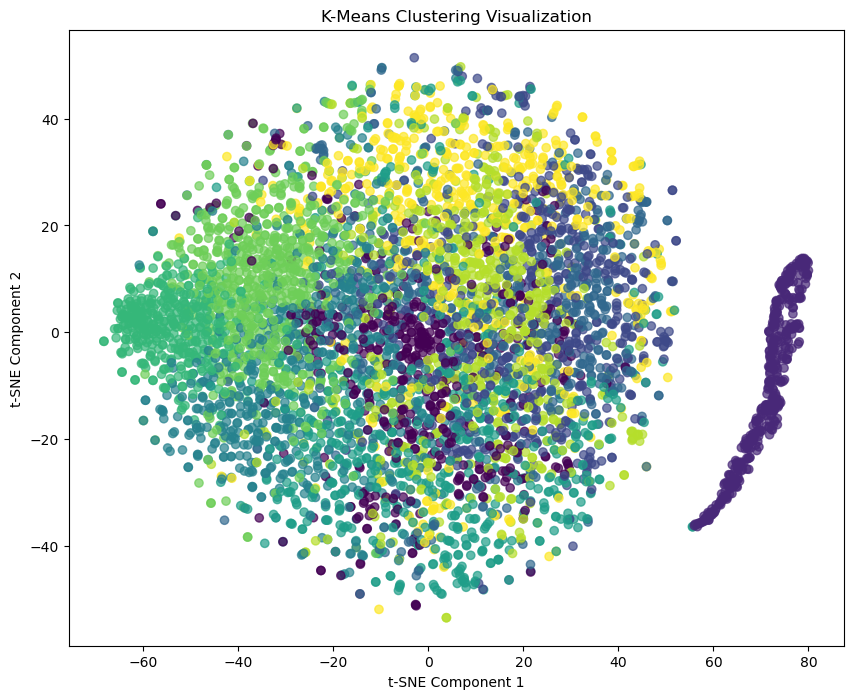

In [15]:
# Visualize the clustering using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(lstm_embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title("K-Means Clustering Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


# Using Alternative AgglomerativeClustering


In [16]:
from sklearn.cluster import AgglomerativeClustering

# Example: Agglomerative hierarchical clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_num_clusters)
cluster_labels_agg = agg_clustering.fit_predict(lstm_embeddings)
silhouette_avg_agg = silhouette_score(lstm_embeddings, cluster_labels_agg)
print(f"Silhouette Score for Agglomerative Clustering: {silhouette_avg_agg}")


Silhouette Score for Agglomerative Clustering: 0.4727139472961426


# Hyperparameter Tuning 

In [17]:
#trying different values for number of clusters
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(lstm_embeddings)
    silhouette_avg = silhouette_score(lstm_embeddings, cluster_labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

Silhouette Score for 2 clusters: 0.4739351272583008
Silhouette Score for 3 clusters: 0.14127089083194733
Silhouette Score for 4 clusters: 0.1256745308637619
Silhouette Score for 5 clusters: 0.1040278747677803
Silhouette Score for 6 clusters: 0.09792953729629517
Silhouette Score for 7 clusters: 0.09511178731918335
Silhouette Score for 8 clusters: 0.09542054682970047
Silhouette Score for 9 clusters: 0.09694063663482666
Silhouette Score for 10 clusters: 0.09559369832277298


# Randomised Search CV

In [21]:
from sklearn.model_selection import RandomizedSearchCV

# Example: Random search for hyperparameter tuning
param_dist = {
    'n_clusters': [2, 3, 4, 5, 6],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 200, 300, 400, 500]
}

random_search = RandomizedSearchCV(KMeans(), param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search_cluster= random_search.fit(lstm_embeddings)
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_clusters': 6, 'max_iter': 400, 'init': 'k-means++'}


# Get movies based on similarity

In [25]:
# Get user input for a movie plot
user_input_plot = input("Enter a movie plot: ")

# Tokenize and pad the user input
user_input_sequence = tokenizer.texts_to_sequences([user_input_plot])
user_input_padded = pad_sequences(user_input_sequence, maxlen=1000, padding='post', truncating='post')


# Get the embedding for the user input
user_input_embedding = model.predict(user_input_padded)


# Find movies in the same cluster as the user input
user_cluster_label = random_search.predict(user_input_embedding)[0]
similar_movies_indices = np.where(cluster_labels == user_cluster_label)[0][:10]
similar_movies = df.iloc[similar_movies_indices]['Movie Title'].tolist()



print(f"\nSimilar Movies based on the entered plot:\n")
for idx, movie in enumerate(similar_movies, start=1):
    print(f"{idx}. {movie}\n")

Enter a movie plot: While in the process of being deported back to India to be produced before the police and ultimately be sent to prison, Tabrez, completely handcuffed, is picked up by CBI officers Chatterjee and Mukherjee, who warns him that he won't be able to escape from prison a 26th time around, but he laughs it off, claiming that he will go home and not to prison. Aboard the flight is aviation minister Pankaj Shukla's daughter Malavika, who gets into an argument with one of the flight attendants over the issue of her pet, Penny. The chief pilot tries to intervene but fails to settle the friction between the two. Tabrez uses this to his advantage by first jacking the cockpit on the pretext of using the washroom and later pushing an asleep Chatterjee's leg out of the seat, which results in the attendant unwittingly losing control and spilling a drink over Penny, causing Malavika to burst into anger, while the pilots come out to resolve the dispute, and discover, to the horror of 